In [22]:
import math
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["SimSun"]
plt.rcParams['axes.unicode_minus'] = False
import numpy as np
M1 = np.array([20000, 0, 2000])
f1 = np.array([17800, 0, 1800])
v_f1 = 120
v_M1 = 300
v_smoke = -3
g = 9.80655
fake_target = np.array([0,0,0])
true_target = np.array([0, 200, 5])  #此为质心，高为10，半径为7
true_target_R = 7
true_target_H = 10
smoke_R = 10
t_list = np.arange(0, 60, 0.005)
true_target_corner_1 = true_target - np.array([0, true_target_R, true_target_H / 2])
true_target_corner_2 = true_target - np.array([0, true_target_R, -true_target_H / 2])
true_target_corner_3 = true_target - np.array([0, -true_target_R, true_target_H / 2])
true_target_corner_4 = true_target - np.array([0, -true_target_R, -true_target_H / 2])
smoke_duration = 20  # 烟雾存续时间


退火优化进度:   0%|          | 0/8000 [00:00<?, ?it/s]

最优参数: [8.14514580e+01 3.09785102e+00 2.29692834e-02 2.65046557e+00]
最大遮挡总时间: 4.732


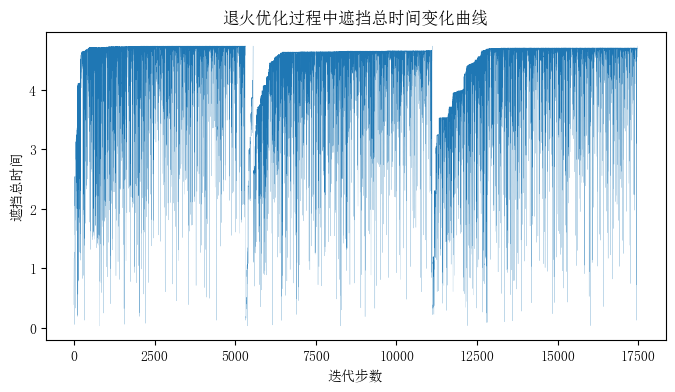

In [23]:
from scipy.optimize import dual_annealing
import matplotlib.pyplot as plt
from calc_cover_time import *

# 优化目标函数
# x: [speed, angle, throw_time, burst_delay]
cover_time_hist = []
missile_traj = get_missile_traj(M1, fake_target, v_M1, t_list)
def sa_objective(x):
    global missile_traj
    position = f1  # 无人机初始点
    speed = x[0]
    direction_angle = x[1]
    throw_time = x[2]
    burst_delay = x[3]
    smoke_center = get_smoke_center(position, direction_angle, speed, throw_time, burst_delay, t_list)
    cover_time = get_missile_cover_time(smoke_center, missile_traj, true_target, smoke_R, t_list)
    cover_time_hist.append(cover_time)
    # 退火算法是最小化，这里返回负值
    return -cover_time

# 参数边界：[速度, 角度, 投弹时间, 爆炸间隔]
bounds = [(70, 140), (np.pi/2, np.pi * 3 / 2), (0, 60), (0, 20)]
from tqdm.notebook import tqdm
max_iter = 8000
pbar = tqdm(total=max_iter, desc="退火优化进度")

# 定义回调函数，每次迭代后更新进度条
def progress_callback(x, f, context):
    pbar.update(1)  # 每次迭代更新进度条
result = dual_annealing(
    func=sa_objective,
    bounds=bounds,
    maxiter=8000,
    seed=123,
    initial_temp=1000,
    callback=progress_callback

)

print('最优参数:', result.x)
print('最大遮挡总时间:', -result.fun)

plt.figure(figsize=(8,4))
plt.plot([cover_time_01 for cover_time_01 in cover_time_hist if cover_time_01 >0], linewidth=0.1, label='遮挡总时间')
plt.xlabel('迭代步数')
plt.ylabel('遮挡总时间')
plt.title('退火优化过程中遮挡总时间变化曲线')
plt.show()


In [24]:
smoke_center_val = get_smoke_center(f1, result.x[1], result.x[0], result.x[2], result.x[3], t_list)
get_missile_cover_time(smoke_center_val, missile_traj, true_target, smoke_R, t_list, debug=True)


遮挡区间: 2.68s ~ 7.41s
总遮挡时间: 4.73s


4.732

In [25]:
from scipy.optimize import dual_annealing
import matplotlib.pyplot as plt


true_target_corners = [true_target_corner_1, true_target_corner_2, true_target_corner_3, true_target_corner_4]
# 优化目标函数
# x: [speed, angle, throw_time, burst_delay]
cover_time_hist = []
missile_traj = get_missile_traj(M1, fake_target, v_M1, t_list)
def sa_objective(x):
    global missile_traj
    position = f1  # 无人机初始点
    speed = x[0]
    direction_angle = x[1]
    throw_time = x[2]
    burst_delay = x[3]
    smoke_center = get_smoke_center(position, direction_angle, speed, throw_time, burst_delay, t_list)
    cover_time = get_missile_cover_time_corners(smoke_center, missile_traj, true_target_corners, smoke_R, t_list)
    cover_time_hist.append(cover_time)
    # 退火算法是最小化，这里返回负值
    return -cover_time

# 参数边界：[速度, 角度, 投弹时间, 爆炸间隔]
bounds = [(70, 140), (np.pi/2, np.pi * 3 / 2), (0, 60), (0, 20)]

from tqdm.notebook import tqdm
max_iter = 4000
pbar = tqdm(total=max_iter, desc="退火优化进度")

# 定义回调函数，每次迭代后更新进度条
def progress_callback(x, f, context):
    pbar.update(1)  # 每次迭代更新进度条


result = dual_annealing(
    func=sa_objective,
    bounds=bounds,
    maxiter=max_iter,
    seed=123,
    initial_temp=1000,
    callback=progress_callback,

)



退火优化进度:   0%|          | 0/4000 [00:00<?, ?it/s]

最优参数: [76.91082632  3.09498753  0.07785901  2.62103018]
最大遮挡总时间: 4.54


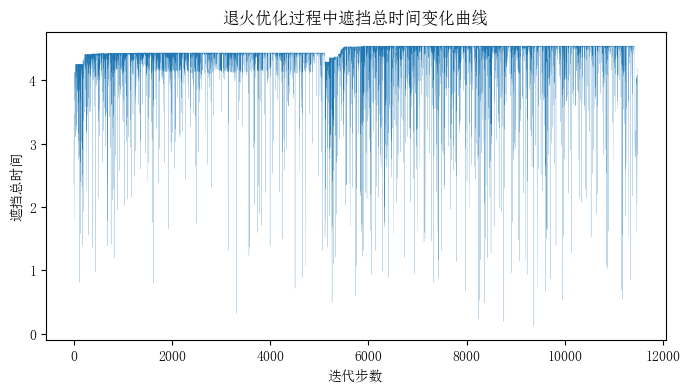

In [26]:
print('最优参数:', result.x)
print('最大遮挡总时间:', -result.fun)

plt.figure(figsize=(8,4))
plt.plot([cover_time_01 for cover_time_01 in cover_time_hist[:22000] if cover_time_01 > 0], linewidth=0.1, label='遮挡总时间')
plt.xlabel('迭代步数')
plt.ylabel('遮挡总时间')
plt.title('退火优化过程中遮挡总时间变化曲线')
plt.show()

In [27]:
smoke_center_val = get_smoke_center(f1, result.x[1], result.x[0], result.x[2], result.x[3], t_list)
get_missile_cover_time_corners(smoke_center_val, missile_traj, true_target_corners, smoke_R, t_list, debug=True)

遮挡区间: 2.78s ~ 7.32s
总遮挡时间: 4.54s


4.54

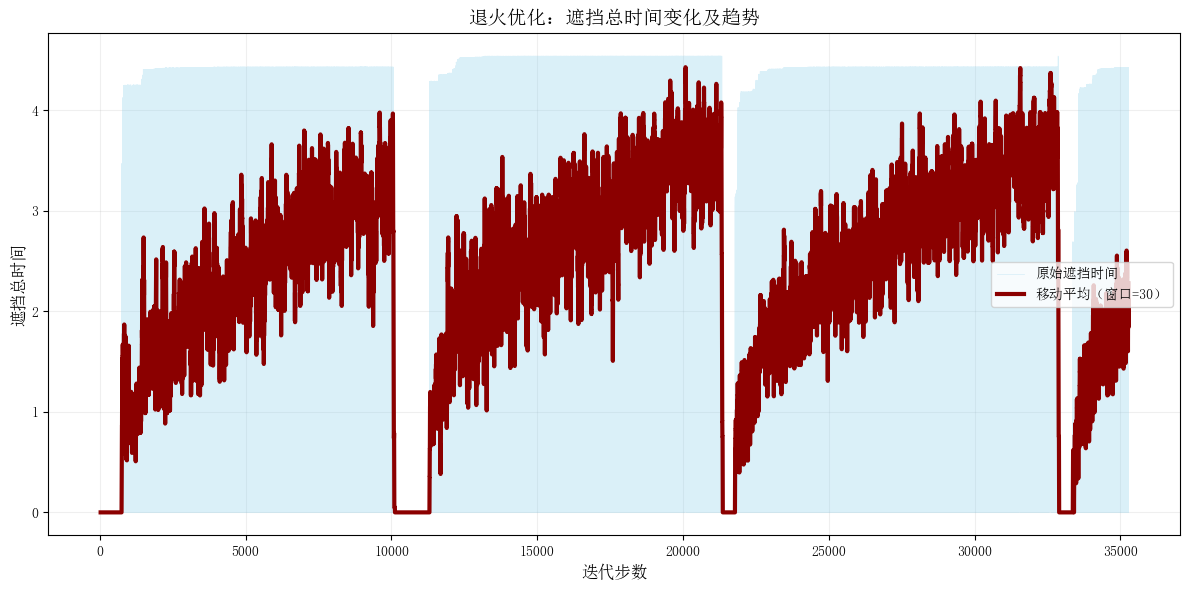

In [28]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 cover_time_hist 是存储所有迭代遮挡时间的列表
ct_series = pd.Series(cover_time_hist)
window_size = 30  # 移动平均窗口大小，可根据数据密度调整
rolling_avg = ct_series.rolling(window=window_size).mean()

# 绘图
plt.figure(figsize=(12, 6))
# 原始数据：透明+细线，避免视觉拥挤
plt.plot(ct_series.index, ct_series.values, 
         color='skyblue', alpha=0.3, linewidth=0.5, 
         label='原始遮挡时间')
# 移动平均：粗线+醒目颜色，突出趋势
plt.plot(rolling_avg.index, rolling_avg.values, 
         color='darkred', linewidth=3, 
         label=f'移动平均（窗口={window_size}）')

# 美化细节
plt.xlabel('迭代步数', fontsize=12)
plt.ylabel('遮挡总时间', fontsize=12)
plt.title('退火优化：遮挡总时间变化及趋势', fontsize=14)
plt.legend(fontsize=10)
plt.grid(alpha=0.2)  # 浅网格增强可读性
plt.tight_layout()   # 自动调整布局
plt.show()

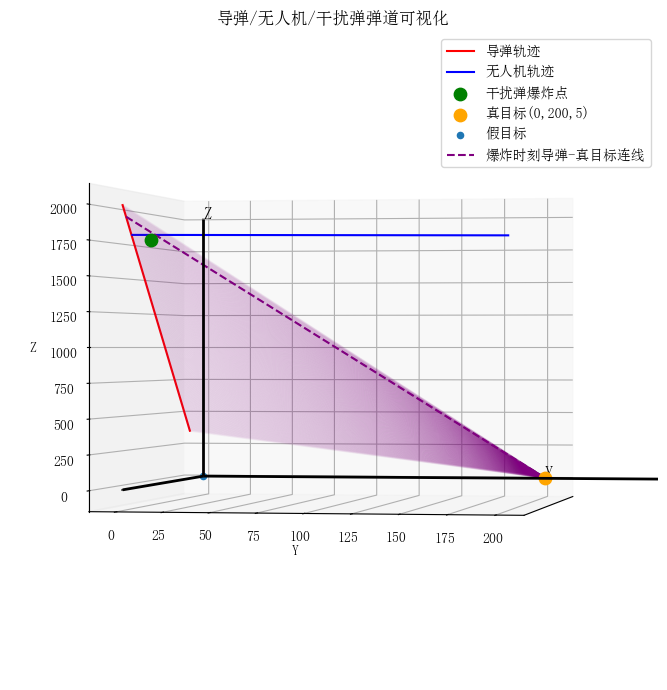

In [49]:

result_for_visualising = [76.91082632,  3.09498753,  0.07785901,  2.62103018]
def plot_missile_drone_smoke_traj(
    missile_start, missile_target, missile_speed,
    t_list,
    drone_start, drone_speed, drone_angle,
    throw_time, burst_delay
):
    """
    可视化：给定时间内一个无人机（只投放一个干扰弹）和一个导弹的弹道
    参数：
        missile_start: np.array([x, y, z]) 导弹初始位置
        missile_target: np.array([x, y, z]) 导弹目标位置
        missile_speed: float 导弹速度
        t_list: np.array 时间序列
        drone_start: np.array([x, y, z]) 无人机初始位置
        drone_speed: float 无人机速度
        drone_angle: float 无人机运动角度（弧度）
        throw_time: float 投弹时间
        burst_delay: float 干扰弹爆炸延迟
    """
    import matplotlib.pyplot as plt

    # 计算导弹轨迹
    missile_traj = get_missile_traj(missile_start, missile_target, missile_speed, t_list)
    # 计算无人机轨迹
    direction = np.array([np.cos(drone_angle), np.sin(drone_angle), 0.0])
    drone_traj = drone_start[:, np.newaxis] + drone_speed * t_list * direction[:, np.newaxis]
    # 计算干扰弹爆炸时刻和位置
    t_burst = throw_time + burst_delay
    smoke_pos = drone_start + direction * drone_speed * t_burst - 0.5 * np.array([0, 0, g]) * burst_delay ** 2

    # 可视化
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # 导弹轨迹
    ax.plot(missile_traj[0], missile_traj[1], missile_traj[2], color='red', label='导弹轨迹')
    # 无人机轨迹
    ax.plot(drone_traj[0], drone_traj[1], drone_traj[2], color='blue', label='无人机轨迹')
    # 干扰弹爆炸点
    ax.scatter(smoke_pos[0], smoke_pos[1], smoke_pos[2], color='green', s=80, label='干扰弹爆炸点')
    # 真目标点
    ax.scatter(0, 200, 5, color='orange', s=80, label='真目标(0,200,5)')
    # 导弹当前位置与真目标连线（每一时刻都画，或只画爆炸时刻）
    # 只画爆炸时刻
    idx_burst = np.argmin(np.abs(t_list - t_burst))
    missile_burst_pos = missile_traj[:, idx_burst]
    ax.scatter(0,0,0, label='假目标')
    ax.plot([missile_burst_pos[0], 0], [missile_burst_pos[1], 200], [missile_burst_pos[2], 5],
            color='purple', linestyle='--', label='爆炸时刻导弹-真目标连线')
    for i in range(missile_traj.shape[1]):
        ax.plot([missile_traj[0, i], 0], [missile_traj[1, i], 200], [missile_traj[2, i], 5],
                color='purple', alpha=0.05)
    # 标注
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_xticks([])
    ax.set_title('导弹/无人机/干扰弹弹道可视化')
    ax.legend()
    plt.tight_layout()
    ax.quiver(0, 0, 0, 20000, 0, 0, color='black', arrow_length_ratio=0.001, linewidth=2)
    ax.quiver(0, 0, 0, 0, 1000, 0, color='black', arrow_length_ratio=0.001, linewidth=2)
    ax.text(0, 200, 0, 'Y', color='black', fontsize=12)
    ax.quiver(0, 0, 0, 0, 0, 2000, color='black', arrow_length_ratio=0.001, linewidth=2)
    ax.text(0, 0, 2000, 'Z', color='black', fontsize=12)

    ax.view_init(elev=0, azim=10)
    plt.show()

plot_missile_drone_smoke_traj(M1, fake_target, v_M1, np.arange(0,55, 0.2), f1, result_for_visualising[0], result_for_visualising[1], result_for_visualising[2], result_for_visualising[3])